In [1]:
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import requests
import numpy as np
import seaborn as sns


In [23]:
df = pd.DataFrame([])
for name in ['Jan','Feb','Mar','Apr','May']:
    tmp = pd.read_excel('HEDNO_overpwr_'+name+'_2024.xlsx', engine='openpyxl')
    tmp = tmp.loc[(tmp['Nr. of power alarms L1']+ tmp['Nr. of power alarms L2'] + tmp['Nr. of power alarms L3'])>0]
    summary = pd.DataFrame(columns=['Installation', 'Transformer', 'Nr. of power alarms',
       'Avg duration of power alarms (minutes)',
       'Avg % of exceeding threshold'])
    
    grouped = tmp.groupby('Transformer')
    for i, group in grouped:


        group['Nr. of power alarms'] = group['Nr. of power alarms L1']+group['Nr. of power alarms L2']+group['Nr. of power alarms L3']
        group['Avg duration of power alarms (minutes)'] = group[['Avg duration of power alarms L1 (min)','Avg duration of power alarms L2 (min)','Avg duration of power alarms L3 (min)']].mean(axis=1)
        group['Avg % of exceeding threshold'] = group[['Avg % of exceeding threshold L1','Avg % of exceeding threshold L2','Avg % of exceeding threshold L3']].mean(axis=1)
        
        #group['Min duration of power alarms'] = np.min(group['Min duration of power alarms L1 (min)'],group['Min duration of power alarms L2 (min)'],group['Min duration of power alarms L3 (min)'])
        #group['Max duration of power alarms'] = np.max(group['Max duration of power alarms L1 (min)'],group['Max duration of power alarms L2 (min)'],group['Max duration of power alarms L3 (min)'])

        group = group.drop(['Nr. of power alarms L1','Avg duration of power alarms L1 (min)','Avg % of exceeding threshold L1','Nr. of power alarms L2','Avg duration of power alarms L2 (min)','Avg % of exceeding threshold L2','Nr. of power alarms L3','Avg duration of power alarms L3 (min)','Avg % of exceeding threshold L3'],axis=1)
        group = pd.DataFrame(group.iloc[0]).transpose()
        summary = summary.append(group, ignore_index=True)

    summary = summary.sort_values(by='Nr. of power alarms', ascending=False)

    # for col in ['Nr. of power alarms','Avg duration of power alarms (minutes)','Avg % of exceeding threshold']:
    #     summary['norm_'+col]=(summary[col] - summary[col].min()) / (summary[col].max() - summary[col].min())
    # weights = [0.5, 1, 0.5]

    # summary['Overpower KPI'] = weights[0]*summary['norm_Nr. of power alarms']*weights[1]*summary['norm_Avg % of exceeding threshold']*weights[2]*summary['norm_Avg duration of power alarms (minutes)']
    # summary = summary.round({'Overpower KPI':2})
    # # summary.to_excel('HEDNO_overpwr_aggregated_'+name+'_2024.xlsx', index=False)
    summary['month'] = name+' 2024'
    # summary = summary[['Installation','Transformer','Overpower KPI','month']]

    df = pd.concat([df,summary])



C:\Users\EmilyP\AppData\Local\Temp\ipykernel_10816\2015885352.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(group, ignore_index=True)
C:\Users\EmilyP\AppData\Local\Temp\ipykernel_10816\2015885352.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(group, ignore_index=True)
C:\Users\EmilyP\AppData\Local\Temp\ipykernel_10816\2015885352.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(group, ignore_index=True)
C:\Users\EmilyP\AppData\Local\Temp\ipykernel_10816\2015885352.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(group,

In [24]:
for col in ['Nr. of power alarms','Avg duration of power alarms (minutes)','Avg % of exceeding threshold']:
    df['norm_'+col]=(df[col] - df[col].min()) / (df[col].max() - df[col].min())
weights = [1, 1, 1]

# df['Overpower KPI'] = 100*weights[0]*df['norm_Nr. of power alarms']*weights[1]*df['norm_Avg % of exceeding threshold']*weights[2]*df['norm_Avg duration of power alarms (minutes)']
df['Overpower KPI'] = weights[0]*df['Nr. of power alarms']*weights[1]*df['Avg % of exceeding threshold']*weights[2]*df['Avg duration of power alarms (minutes)']
df = df.round({'Overpower KPI':2})


In [21]:
# Get the minimum and maximum values of the column
col_min = df['Overpower KPI'].min()
col_max = df['Overpower KPI'].max()

# Define the desired range
desired_min = 0.1
desired_max = 100

# Normalize the column to the range [0.1, 100]
df['normalized_column'] = desired_min + (df['Overpower KPI'] - col_min) * (desired_max - desired_min) / (col_max - col_min)
df['Overpower KPI'] = df['normalized_column'] 


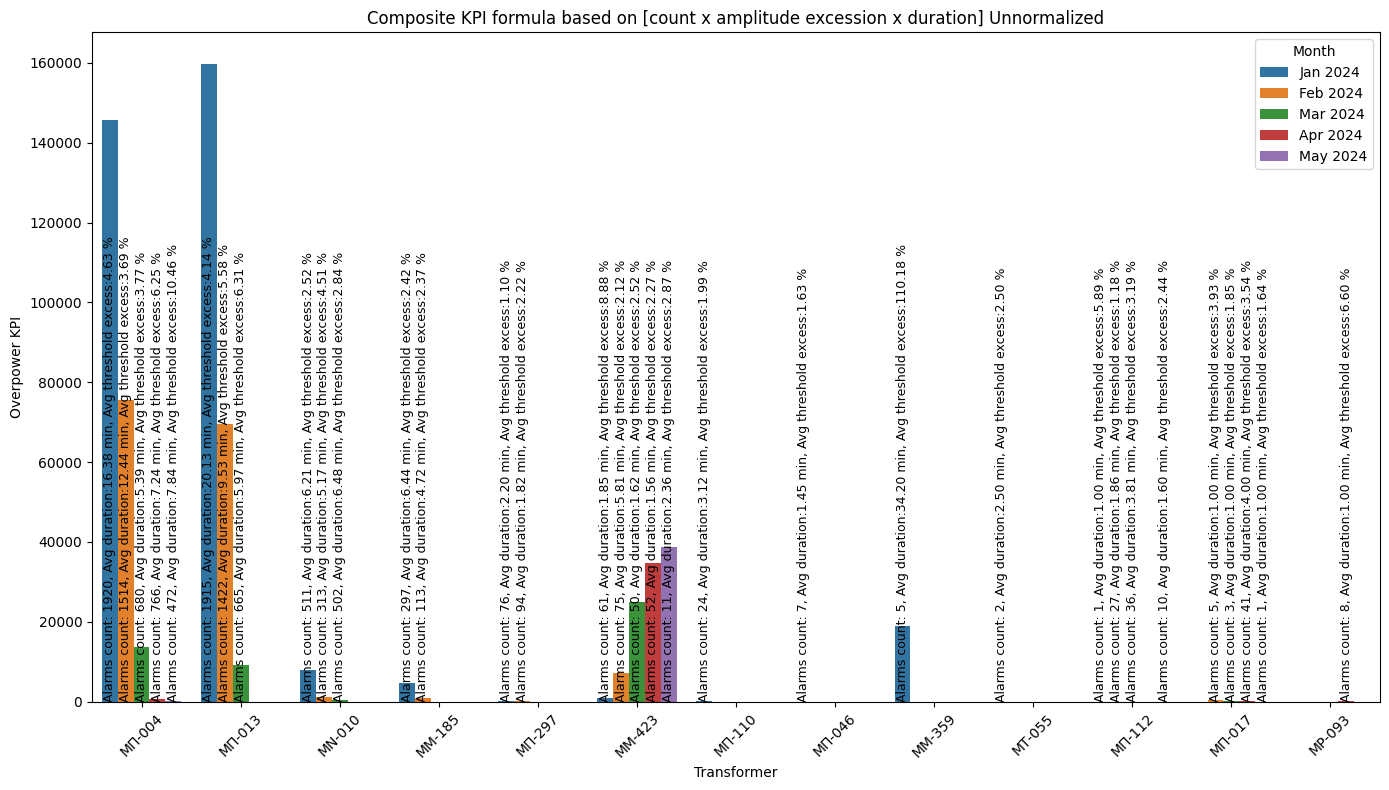

In [26]:
# 2D plot

# Create the grouped bar plot
fig = plt.figure(figsize=(14, 8))
barplot  = sns.barplot(data=df, x='Transformer', y='Overpower KPI', hue='month')

# Set plot labels and title
plt.xlabel('Transformer')
plt.ylabel('Overpower KPI')
# plt.title('Composite KPI based on count/amplitude excession/duration with weights '+str(weights[0])+' / '+str(weights[1])+' / '+str(weights[2]))
plt.title('Composite KPI formula based on [count x amplitude excession x duration] Unnormalized')
plt.xticks(rotation=45)
plt.legend(title='Month')
plt.tight_layout()
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        # Get the index of the bar in the plot
        bar_index = barplot.patches.index(p)
        
        # Find the corresponding row in the DataFrame
        row = df.iloc[bar_index]
        
        # Extract the values for the annotation
        nr_power_alarms = row['Nr. of power alarms']
        avg_duration = row['Avg duration of power alarms (minutes)']
        avg_excess = row['Avg % of exceeding threshold']
        # Create the annotation label
        label = f'Alarms count: {nr_power_alarms}, Avg duration:{avg_duration:.2f} min, Avg threshold excess:{avg_excess:.2f} %'
        
        # Annotate the bar
        barplot.text(p.get_x() + p.get_width() / 2., 0,
                     label, ha='center', va='bottom', rotation=90, fontsize=9, color='black')

        # barplot.text(p.get_x() + p.get_width() / 2., height / 2,
        #              label, ha='center', va='center', rotation=90, fontsize=9, color='white')

plt.savefig('groupedPowerKPI_unnormalized_product_labels.png', dpi=300)
# Show the plot
plt.show()

In [66]:
df.to_excel('aggregated_normalized.xlsx', index=False)